# "NoData" Handling

## What is NoData?

In raster operations, the preservation and correct processing of missing observations is very important. In [most DataFrames and in scientific computing](https://www.oreilly.com/learning/handling-missing-data), the idea of missing data is expressed as a `null` or `NaN` value. However, a great deal of raster data is stored for space efficiency, which typically leads to use of integral values with a ["sentinel" value](https://en.wikipedia.org/wiki/Sentinel_value) designated to represent missing observations. This sentinel value varies across data products and bands. In a generic sense, it is usually called the "NoData" value.

RasterFrames provides a variety of functions to inspect and manage NoData within _tiles_.

## Cell Types

To understand how NoData is handled in RasterFrames, we first need to understand the different underlying types of data called cell types. RasterFrames cell types are GeoTrellis `CellType`s, so the [GeoTrellis documentation](https://geotrellis.readthedocs.io/en/latest/guide/core-concepts.html?#working-with-cell-values) is a valuable resource on how these are defined.



In [1]:
import pyrasterframes
from pyrasterframes.utils import create_rf_spark_session
from pyrasterframes.rasterfunctions import *
import pyrasterframes.rf_ipython
from IPython.display import display
import pandas as pd
import numpy as np
from pyrasterframes.rf_types import Tile

spark = create_rf_spark_session()


The `CellType` class from the `rf_types` submodule allows us to create a representation of any valid cell type. There are convenience methods to create instances for a variety of basic types.



In [2]:
from pyrasterframes.rf_types import CellType
CellType.bool()
CellType.int8()
CellType.uint8()
CellType.int16()
CellType.uint16()
CellType.int32()
CellType.float32()
CellType.float64()

float64


We can also inspect the cell type of a given _tile_ or `proj_raster` column.



In [3]:
cell_types = spark.read.raster('https://s22s-test-geotiffs.s3.amazonaws.com/luray_snp/B02.tif') \
    .select(rf_cell_type('proj_raster')).distinct()
cell_types

rf_cell_type(proj_raster)
[uint16raw]



### Understanding Cell Types and NoData

We can use the methods on the `CellType` class to learn more about a specific cell type. Let's consider the cell type of our sample data above.



In [4]:
ct = CellType('uint16raw')
ct, ct.is_floating_point(), ct.has_no_data()

(uint16raw, False, False)


We can see that for the above data source, there is no defined NoData value. This means that each value is interpreted as a valid observation. Often such data is meant to be combined with another band indicating the quality of observations at each location. The lack of NoData is indicated by the `raw` at the end of the type name. Consider for contrast the `uint16` cell type.



In [5]:
from pyrasterframes.rf_types import CellType
ct = CellType('uint16')
ct, ct.is_floating_point(), ct.has_no_data(), ct.no_data_value()

(uint16, False, True, 0)


In this case, the minimum value of 0 is designated as the NoData value. For integral-valued cell types, the NoData is typically zero, the maximum, or the minimum value for the underlying data type. The NoData value can also be a user-defined value. In that case the value is designated with `ud`.



In [6]:
CellType.uint16().with_no_data_value(99).cell_type_name

'uint16ud99'


Floating point types have `NaN` as the NoData value by default. However, a user-defined NoData can be set.



In [7]:
print(CellType.float32().no_data_value())
print(CellType.float32().with_no_data_value(-99.9).no_data_value())

nan
-99.9



## NoData and Local Arithmetic

Let's now explore how the presence of NoData affects @ref:[local map algebra](local-algebra.md) operations. To demonstrate the behavior, lets create two _tiles_. One _tile_ will have values of 0 and 1, and the other will have values of just 0.



x


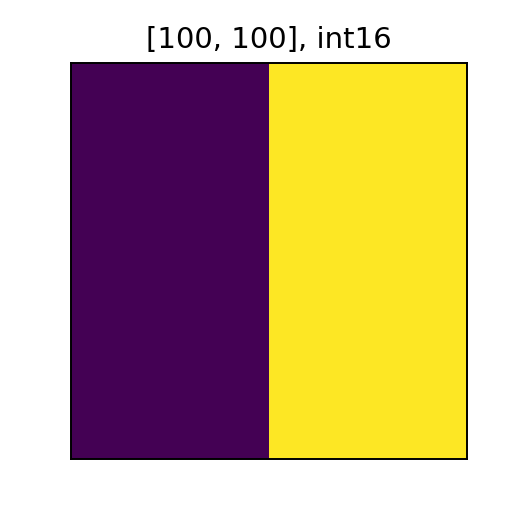

In [8]:
tile_size = 100
x = np.zeros((tile_size, tile_size), dtype='int16')
x[:,tile_size//2:] = 1
x = Tile(x)
y = Tile(np.zeros((tile_size, tile_size), dtype='int16'))

rf = spark.createDataFrame([Row(x=x, y=y)])
print('x')
display(x)

y


/anaconda3/envs/rf-docs/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/anaconda3/envs/rf-docs/lib/python3.7/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/anaconda3/envs/rf-docs/lib/python3.7/site-packages/matplotlib/image.py:413: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/anaconda3/envs/rf-docs/lib/python3.7/site-packages/matplotlib/image.py:418: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/anaconda3/envs/rf-docs/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


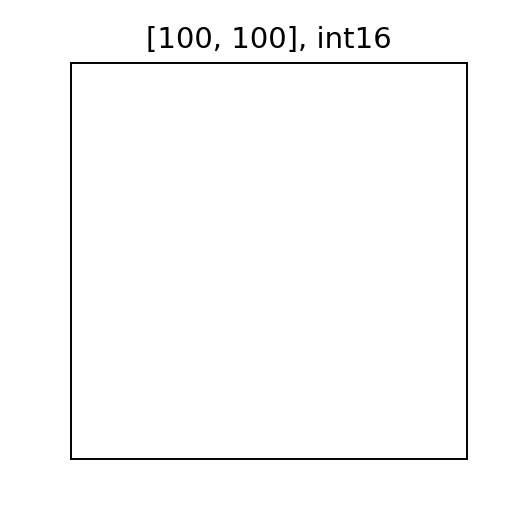

In [9]:
print('y')
display(y)


Now, let's create a new column from `x` with the value of 1 changed to NoData. Then, we will add this new column with NoData to the `y` column. As shown below, the result of the sum also has NoData (represented in white). In general for local algebra operations, Data + NoData = NoData.



x with NoData


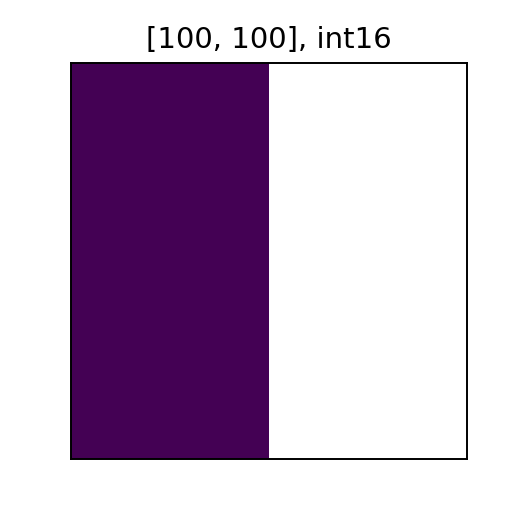

In [10]:
masked_rf = rf.withColumn('x_nd', rf_mask_by_value('x', 'x', lit(1)) )
masked_rf = masked_rf.withColumn('x_nd_y_sum', rf_local_add('x_nd', 'y'))
row = masked_rf.collect()[0]
print('x with NoData')
display(row.x_nd)

x with NoData plus y


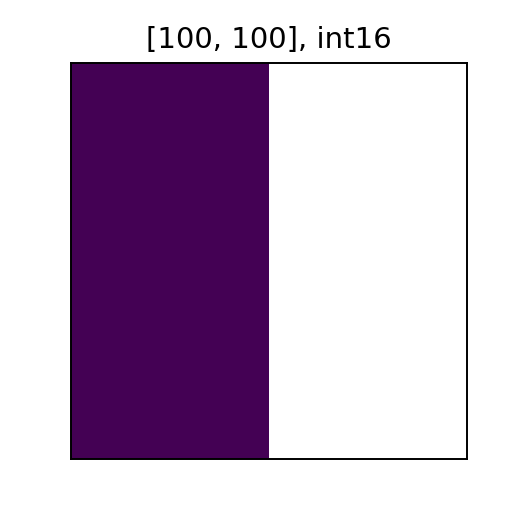

In [11]:
print('x with NoData plus y')
display(row.x_nd_y_sum)

To see more information about possible operations on _tile_ columns, see the @ref:[local map algebra](local-algebra.md) page and @ref:[function reference](reference.md#local-map-algebra).

## Changing a Tile's NoData Values

One way to mask a _tile_ is to make a new _tile_ with a user defined NoData value. We will explore this method below. First, lets create a DataFrame from a _tile_ with values of 0, 1, 2, and 3. We will use numpy to create a 100x100 _tile_ with vertical bands containing values 0, 1, 2, and 3.



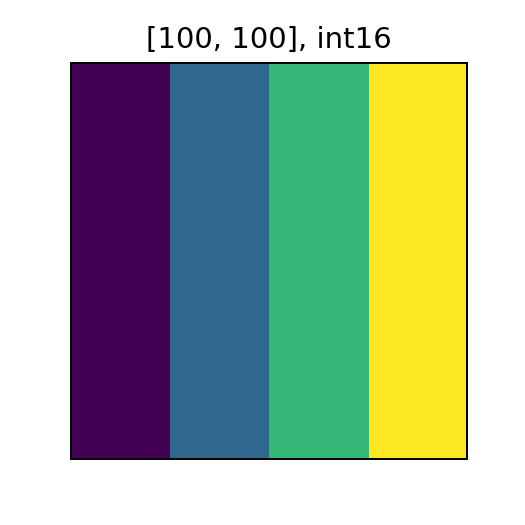

In [12]:
tile_size = 100
x = np.zeros((tile_size, tile_size), dtype='int16')

# setting the values of the columns
for i in range(4):
    x[:, i*tile_size//4:(i+1)*tile_size//4] = i
x = Tile(x)

rf = spark.createDataFrame([Row(tile=x)])
display(x)


First, we mask the value of 1 by making a new _tile_ column with the user defined cell type 'uint16ud1'. Then, we mask out the value of two by making a _tile_ column with the cell type 'uint16ud2'.



In [13]:
def get_nodata_ct(nd_val):
	return CellType('uint16').with_no_data_value(nd_val)

masked_rf = rf.withColumn('tile_nd_1',
                           rf_convert_cell_type('tile', get_nodata_ct(1))) \
              .withColumn('tile_nd_2',
                          rf_convert_cell_type('tile_nd_1', get_nodata_ct(2))) \

In [14]:
collected = masked_rf.collect()


Let's look at the new _tiles_ we created. The _tile_ named `tile_nd_1` has the 1 values masked out as expected.



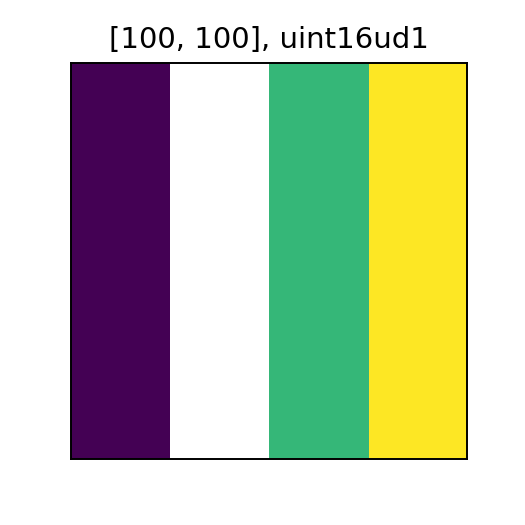

In [15]:
display(collected[0].tile_nd_1)


And the _tile_ named `tile_nd_2` has the values of 1 and 2 masked out. This is because we created the _tile_ by setting a new user defined NoData value to `tile_nd_1`, and the values previously masked out in `tile_nd_1` stayed masked when creating `tile_nd_2`.



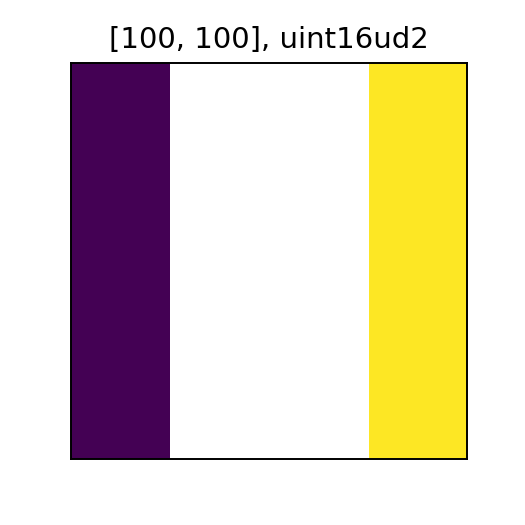

In [16]:
display(collected[0].tile_nd_2)



## Combining Tiles with Different Data Types

RasterFrames supports having _tile_ columns with different cell types in a single DataFrame. It is important to understand how these different cell types interact.

Let's first create a RasterFrame that has columns of `float` and `int` cell type.



In [17]:
x = Tile((np.ones((100, 100))*2), CellType.float64())
y = Tile((np.ones((100, 100))*3), CellType.int32())
rf = spark.createDataFrame([Row(x=x, y=y)])

cell_types = rf.select(rf_cell_type('x'), rf_cell_type('y')).distinct()
cell_types

rf_cell_type(x),rf_cell_type(y)
[float64],[int32]



When performing a local operation between _tile_ columns with cell types `int` and  `float`, the resulting _tile_ cell type will be `float`. In local algebra over two _tiles_ of different "sized" cell types, the resulting cell type will be the larger of the two input _tiles'_ cell types.



In [18]:
sums = rf.select(
    rf_cell_type('x'),
    rf_cell_type('y'),
    rf_cell_type(rf_local_add('x', 'y')).alias('xy_sum'),
    )
sums

rf_cell_type(x),rf_cell_type(y),xy_sum
[float64],[int32],[float64]



Combining _tile_ columns of different cell types gets a little trickier when user defined NoData cell types are involved. Let's create two _tile_ columns: one with a NoData value of 1, and one with a NoData value of 2 (using our previously defined `get_nodata_ct` function).



In [19]:
x_nd_1 = Tile((np.ones((100, 100))*3), get_nodata_ct(1))
x_nd_2 = Tile((np.ones((100, 100))*3), get_nodata_ct(2))
rf_nd = spark.createDataFrame([Row(x_nd_1=x_nd_1, x_nd_2=x_nd_2)])


Let's try adding the _tile_ columns with different NoData values. When there is an inconsistent NoData value in the two columns, the NoData value of the right-hand side of the sum is kept. In this case, this means the result has a NoData value of 1.



In [20]:
rf_nd_sum = rf_nd.withColumn('x_nd_sum', rf_local_add('x_nd_2', 'x_nd_1'))
cell_types = rf_nd_sum.select(rf_cell_type('x_nd_sum')).distinct()
cell_types

rf_cell_type(x_nd_sum)
[uint16ud2]



Reversing the order of the sum changes the NoData value of the resulting column to 2.



In [21]:
rf_nd_sum = rf_nd.withColumn('x_nd_sum', rf_local_add('x_nd_1', 'x_nd_2'))
cell_types = rf_nd_sum.select(rf_cell_type('x_nd_sum')).distinct()
cell_types

rf_cell_type(x_nd_sum)
[uint16ud1]



## NoData Values in Aggregation

Let's use the same _tile_ as before to demonstrate how NoData values affect _tile_ aggregations.



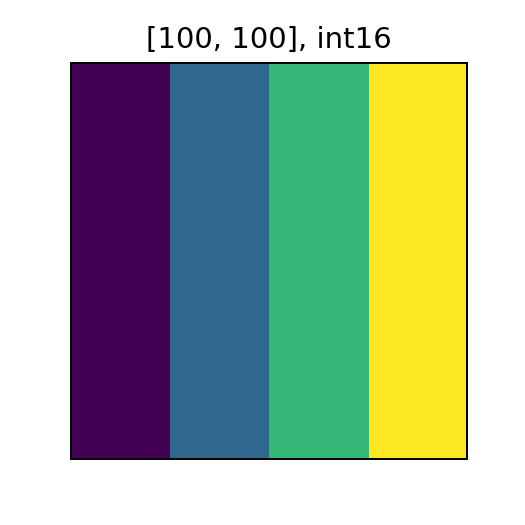

In [22]:
tile_size = 100
x = np.zeros((tile_size, tile_size))
for i in range(4):
    x[:, i*tile_size//4:(i+1)*tile_size//4] = i
x = Tile(x, CellType.int16())

rf = spark.createDataFrame([Row(tile=x)])
display(x)


First we create the two new masked _tile_ columns as before. One with only the value of 1 masked, and the other with and values of 1 and 2 masked.



In [23]:
masked_rf = rf.withColumn('tile_nd_1',
                           rf_convert_cell_type('tile', get_nodata_ct(1))) \
              .withColumn('tile_nd_2',
                          rf_convert_cell_type('tile_nd_1', get_nodata_ct(2)))


The results of `rf_tile_sum` vary on the _tiles_ that were masked. This is because any cells with NoData values are ignored in the aggregation. Note that `tile_nd_2` has the lowest sum, since it has the fewest amount of data cells.



In [24]:
sums = masked_rf.select(rf_tile_sum('tile'), rf_tile_sum('tile_nd_1'), rf_tile_sum('tile_nd_2'))
sums

rf_tile_sum(tile),rf_tile_sum(tile_nd_1),rf_tile_sum(tile_nd_2)
15000.0,12500.0,7500.0
